In [ ]:
# ✅ Install Required Libraries
!pip install transformers keras tensorflow wandb datasets nltk emoji --quiet

# ✅ NLTK Downloads
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# ✅ HuggingFace Login
import os
from dotenv import load_dotenv

# Load variables from .env
load_dotenv()

# Get token
hf_token = os.getenv("HF_TOKEN")

# Login securely
from huggingface_hub import login
login(token=hf_token)  # ← Replace with your actual token if needed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platfo

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# ✅ Torch & Vision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import resnet50, vgg16, vgg19

# ✅ Other Essentials
import numpy as np
import pandas as pd
import random
import os, re, string
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# ✅ NLP & Transformers
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji  # 🟢 For emoji removal

# ✅ ML & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# ✅ WandB (optional experiment tracking)
import wandb

# ✅ Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# ✅ Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# Load dataset (from HuggingFace Hub)
dataset = load_dataset("anson-huang/mirage-news")
df = dataset["train"].to_pandas()

# Basic checks
print(" Dataset loaded with shape:", df.shape)
print(" Columns:", df.columns.tolist())
print("\n Label Distribution:\n", df['label'].value_counts())
print("\n Missing Values:\n", df.isnull().sum())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/655M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/143M [00:00<?, ?B/s]

test1_nyt_mj-00000-of-00001.parquet:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

test2_bbc_dalle-00000-of-00002.parquet:   0%|          | 0.00/560M [00:00<?, ?B/s]

test2_bbc_dalle-00001-of-00002.parquet:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

test3_cnn_dalle-00000-of-00002.parquet:   0%|          | 0.00/559M [00:00<?, ?B/s]

test3_cnn_dalle-00001-of-00002.parquet:   0%|          | 0.00/25.8M [00:00<?, ?B/s]

test4_bbc_sdxl-00000-of-00001.parquet:   0%|          | 0.00/46.0M [00:00<?, ?B/s]

test5_cnn_sdxl-00000-of-00001.parquet:   0%|          | 0.00/54.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2500 [00:00<?, ? examples/s]

Generating test1_nyt_mj split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test2_bbc_dalle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test3_cnn_dalle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test4_bbc_sdxl split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test5_cnn_sdxl split:   0%|          | 0/500 [00:00<?, ? examples/s]

 Dataset loaded with shape: (10000, 3)
 Columns: ['image', 'label', 'text']

 Label Distribution:
 label
1    5000
0    5000
Name: count, dtype: int64

 Missing Values:
 image    0
label    0
text     0
dtype: int64


In [4]:
# Load dataset (from HuggingFace Hub)
dataset = load_dataset("anson-huang/mirage-news")
df = dataset["train"].to_pandas()

# Basic checks
print(" Dataset loaded with shape:", df.shape)
print(" Columns:", df.columns.tolist())
print("\n Label Distribution:\n", df['label'].value_counts())
print("\n Missing Values:\n", df.isnull().sum())

 Dataset loaded with shape: (10000, 3)
 Columns: ['image', 'label', 'text']

 Label Distribution:
 label
1    5000
0    5000
Name: count, dtype: int64

 Missing Values:
 image    0
label    0
text     0
dtype: int64


In [5]:
import nltk

# Download everything needed for:
# - Tokenizing words (punkt)
# - Lemmatizing nouns/verbs/adjectives (wordnet)
# - POS tagging for lemmatization (averaged_perceptron_tagger)
# - Stopwords removal (stopwords)

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')

import nltk

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
# ✅ Install & Imports
!pip install datasets opencv-python-headless --quiet

import numpy as np
import pandas as pd
import re, string, emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# ✅ NLTK Setup
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# ✅ Load Mirage-News Dataset
dataset = load_dataset("anson-huang/mirage-news")
df = dataset["train"].to_pandas()

# ✅ Drop missing entries
df = df.dropna(subset=["text", "image"])
df = df[df["text"].str.strip() != ""]
print("✅ Total usable samples:", len(df))

# ✅ Preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = emoji.replace_emoji(text, "")
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and w.isalpha()]
    return " ".join(tokens)

# ✅ Clean text column
df["clean_text"] = df["text"].apply(clean_text)

# ✅ Balance dataset: 5000 samples per class
df_0 = df[df["label"] == 0].sample(n=5000, random_state=42)
df_1 = df[df["label"] == 1].sample(n=5000, random_state=42)
balanced_df = pd.concat([df_0, df_1], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

# ✅ Split dataset
train_df, temp_df = train_test_split(balanced_df, test_size=0.3, stratify=balanced_df["label"], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

# ✅ Extract text, label, image path lists
train_texts = train_df["clean_text"].tolist()
train_labels = train_df["label"].tolist()
train_image_paths = train_df["image"].tolist()

valid_texts = valid_df["clean_text"].tolist()
valid_labels = valid_df["label"].tolist()
valid_image_paths = valid_df["image"].tolist()

test_texts = test_df["clean_text"].tolist()
test_labels = test_df["label"].tolist()
test_image_paths = test_df["image"].tolist()

# ✅ Confirm sizes
print(f"✅ Train size: {len(train_texts)}, Validation size: {len(valid_texts)}, Test size: {len(test_texts)}")

# ✅ Save to .npy files
np.save("train_texts.npy", np.array(train_texts))
np.save("train_labels.npy", np.array(train_labels))
np.save("train_image_paths.npy", np.array(train_image_paths))

np.save("valid_texts.npy", np.array(valid_texts))
np.save("valid_labels.npy", np.array(valid_labels))
np.save("valid_image_paths.npy", np.array(valid_image_paths))

np.save("test_texts.npy", np.array(test_texts))
np.save("test_labels.npy", np.array(test_labels))
np.save("test_image_paths.npy", np.array(test_image_paths))

print("✅ Saved all data splits as .npy files")

# ✅ Download if using Colab
try:
    from google.colab import files
    for fname in [
        "train_texts.npy", "train_labels.npy", "train_image_paths.npy",
        "valid_texts.npy", "valid_labels.npy", "valid_image_paths.npy",
        "test_texts.npy", "test_labels.npy", "test_image_paths.npy"
    ]:
        files.download(fname)
except:
    print("🔁 Skipping file download (not running in Colab)")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Total usable samples: 10000
✅ Train size: 7000, Validation size: 1500, Test size: 1500
✅ Saved all data splits as .npy files


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
print("🔹 Train Sample")
print("Text:", train_texts[0])
print("Label:", train_labels[0])
print("Image Path:", train_image_paths[0])
print("-" * 60)

print("🔹 Validation Sample")
print("Text:", valid_texts[0])
print("Label:", valid_labels[0])
print("Image Path:", valid_image_paths[0])
print("-" * 60)

print("🔹 Test Sample")
print("Text:", test_texts[0])
print("Label:", test_labels[0])
print("Image Path:", test_image_paths[0])
print("-" * 60)

🔹 Train Sample
Text: nina phillips dismissed teaching position p brooklyn last month
Label: 1
Image Path: {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\x90\x02X\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2

In [8]:
import nltk
import pandas as pd
import torch
import numpy as np
from transformers import BertModel, BertTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm

# ✅ Download sentiment tool
nltk.download('vader_lexicon')

# ✅ Init tools
vader = SentimentIntensityAnalyzer()
bert_model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device).eval()

# ✅ Tokenizer
def tokenize_batch(text_batch, max_length=128):
    return tokenizer(
        text_batch,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# ✅ Sentiment
def get_vader_scores(text):
    scores = vader.polarity_scores(text)
    return scores["neg"], scores["neu"], scores["pos"], scores["compound"]

# ✅ Batched embedding generation
def get_batched_embeddings(texts, sentiment_scores, batch_size=32):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        batch_scores = sentiment_scores[i:i+batch_size]

        encodings = tokenize_batch(batch_texts)
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)

        with torch.no_grad():
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token

        sentiment_tensor = torch.tensor(batch_scores).float().to(device)
        batch_combined = torch.cat((cls_embeddings, sentiment_tensor), dim=1)
        all_embeddings.append(batch_combined.cpu().numpy())

    return np.vstack(all_embeddings)

# ✅ Process splits
for name, df in [("train", train_df), ("valid", valid_df), ("test", test_df)]:
    print(f"\n🔄 Processing {name} split...")

    # Sentiment
    df[["sent_neg", "sent_neu", "sent_pos", "sent_compound"]] = df["clean_text"].apply(
        lambda x: pd.Series(get_vader_scores(x))
    )
    print(f"✅ Sentiment scores added for {name}")

    sentiment_scores = df[["sent_neg", "sent_neu", "sent_pos", "sent_compound"]].values.tolist()

    # BERT + Sentiment embeddings in batches
    embeddings = get_batched_embeddings(df["clean_text"].tolist(), sentiment_scores, batch_size=32)

    # Save
    np.save(f"{name}_bert_sentiment_embeddings.npy", embeddings)
    print(f"💾 Saved {name}_bert_sentiment_embeddings.npy | shape: {embeddings.shape}")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


🔄 Processing train split...
✅ Sentiment scores added for train


100%|██████████| 219/219 [41:42<00:00, 11.43s/it]


💾 Saved train_bert_sentiment_embeddings.npy | shape: (7000, 772)

🔄 Processing valid split...
✅ Sentiment scores added for valid


100%|██████████| 47/47 [08:47<00:00, 11.23s/it]


💾 Saved valid_bert_sentiment_embeddings.npy | shape: (1500, 772)

🔄 Processing test split...
✅ Sentiment scores added for test


100%|██████████| 47/47 [08:46<00:00, 11.20s/it]

💾 Saved test_bert_sentiment_embeddings.npy | shape: (1500, 772)


In [9]:
import torch
from torchvision import models, transforms
from PIL import Image
import io
import numpy as np
from tqdm import tqdm

# ✅ Load pretrained models with weights (fix deprecation warnings)
from torchvision.models import ResNet50_Weights, VGG16_Weights, VGG19_Weights

# Load models on CPU first
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
vgg19 = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)

# ✅ Move models to device (GPU if available) later during inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Use mixed precision
from torch.cuda.amp import autocast

# ✅ Preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Convert image bytes to tensor
def preprocess_image(image_bytes):
    try:
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        image_tensor = transform(image)
        return image_tensor
    except Exception as e:
        print("⚠️ Skipped image due to error:", e)
        return torch.zeros((3, 224, 224))  # Placeholder image

# ✅ Batch feature extraction
def extract_features_for_split(df, model, model_name, split_name, batch_size=8):  # Reduced batch size
    all_features = []

    # Preprocess all images
    images = [preprocess_image(img["bytes"]) for img in df["image"]]

    # Batch and extract features
    for i in tqdm(range(0, len(images), batch_size), desc=f"{split_name}_{model_name}"):
        batch_images = torch.stack(images[i:i+batch_size]).to(device)

        # Perform inference with mixed precision (float16)
        with torch.no_grad(), autocast():
            batch_features = model(batch_images)

        all_features.append(batch_features.cpu().numpy())

        # Free up memory to avoid OOM
        del batch_images, batch_features
        torch.cuda.empty_cache()

    all_features = np.vstack(all_features)
    np.save(f"{split_name}_{model_name}_features.npy", all_features)
    print(f"💾 Saved: {split_name}_{model_name}_features.npy → shape: {all_features.shape}")
    return all_features

# ✅ Free all memory before starting
torch.cuda.empty_cache()

# ✅ Extract features for ResNet50 first, then clear memory
print("🔍 Extracting ResNet50 image features in batches...")

# Transfer model to GPU
resnet50 = resnet50.to(device)
train_resnet_features = extract_features_for_split(train_df, resnet50, "resnet50", "train")
valid_resnet_features = extract_features_for_split(valid_df, resnet50, "resnet50", "valid")
test_resnet_features  = extract_features_for_split(test_df,  resnet50, "resnet50", "test")

# Clear memory before moving to next model
del resnet50
torch.cuda.empty_cache()

# ✅ Extract features for VGG16
print("🔍 Extracting VGG16 image features in batches...")

# Transfer model to GPU
vgg16 = vgg16.to(device)
train_vgg16_features = extract_features_for_split(train_df, vgg16, "vgg16", "train")
valid_vgg16_features = extract_features_for_split(valid_df, vgg16, "vgg16", "valid")
test_vgg16_features  = extract_features_for_split(test_df,  vgg16, "vgg16", "test")

# Clear memory before moving to next model
del vgg16
torch.cuda.empty_cache()

# ✅ Extract features for VGG19
print("🔍 Extracting VGG19 image features in batches...")

# Transfer model to GPU
vgg19 = vgg19.to(device)
train_vgg19_features = extract_features_for_split(train_df, vgg19, "vgg19", "train")
valid_vgg19_features = extract_features_for_split(valid_df, vgg19, "vgg19", "valid")
test_vgg19_features  = extract_features_for_split(test_df,  vgg19, "vgg19", "test")

# Clear memory before finishing
del vgg19
torch.cuda.empty_cache()

# ✅ Verify output shapes
print(f"✅ ResNet50 train feature shape: {train_resnet_features.shape}")
print(f"✅ VGG16 train feature shape:   {train_vgg16_features.shape}")
print(f"✅ VGG19 train feature shape:   {train_vgg19_features.shape}")

# ✅ Optional: Colab file download
try:
    from google.colab import files
    for model in ["resnet50", "vgg16", "vgg19"]:
        for split in ["train", "valid", "test"]:
            files.download(f"{split}_{model}_features.npy")
except:
    print("📦 Skipping download step (not running in Colab)")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 60.5MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:17<00:00, 32.4MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 62.3MB/s]


🔍 Extracting ResNet50 image features in batches...


train_resnet50:   0%|          | 0/875 [00:00<?, ?it/s]<ipython-input-9-76b77108ad35>:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
train_resnet50: 100%|██████████| 875/875 [25:47<00:00,  1.77s/it]


💾 Saved: train_resnet50_features.npy → shape: (7000, 1000)


valid_resnet50: 100%|██████████| 188/188 [05:17<00:00,  1.69s/it]


💾 Saved: valid_resnet50_features.npy → shape: (1500, 1000)


test_resnet50: 100%|██████████| 188/188 [05:13<00:00,  1.67s/it]


💾 Saved: test_resnet50_features.npy → shape: (1500, 1000)
🔍 Extracting VGG16 image features in batches...


train_vgg16: 100%|██████████| 875/875 [1:08:31<00:00,  4.70s/it]


💾 Saved: train_vgg16_features.npy → shape: (7000, 1000)


valid_vgg16: 100%|██████████| 188/188 [13:13<00:00,  4.22s/it]


💾 Saved: valid_vgg16_features.npy → shape: (1500, 1000)


test_vgg16: 100%|██████████| 188/188 [13:11<00:00,  4.21s/it]


💾 Saved: test_vgg16_features.npy → shape: (1500, 1000)
🔍 Extracting VGG19 image features in batches...


train_vgg19: 100%|██████████| 875/875 [1:24:03<00:00,  5.76s/it]


💾 Saved: train_vgg19_features.npy → shape: (7000, 1000)


valid_vgg19: 100%|██████████| 188/188 [16:17<00:00,  5.20s/it]


💾 Saved: valid_vgg19_features.npy → shape: (1500, 1000)


test_vgg19: 100%|██████████| 188/188 [16:16<00:00,  5.19s/it]

💾 Saved: test_vgg19_features.npy → shape: (1500, 1000)
✅ ResNet50 train feature shape: (7000, 1000)
✅ VGG16 train feature shape:   (7000, 1000)
✅ VGG19 train feature shape:   (7000, 1000)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
import numpy as np

# ✅ Load saved features
train_resnet_features = np.load("train_resnet50_features.npy")
valid_resnet_features = np.load("valid_resnet50_features.npy")
test_resnet_features  = np.load("test_resnet50_features.npy")

train_vgg16_features = np.load("train_vgg16_features.npy")
valid_vgg16_features = np.load("valid_vgg16_features.npy")
test_vgg16_features  = np.load("test_vgg16_features.npy")

train_vgg19_features = np.load("train_vgg19_features.npy")
valid_vgg19_features = np.load("valid_vgg19_features.npy")
test_vgg19_features  = np.load("test_vgg19_features.npy")

# ✅ Combine the features and compute the average for each image
train_combined_features = np.mean([train_resnet_features, train_vgg16_features, train_vgg19_features], axis=0)
valid_combined_features = np.mean([valid_resnet_features, valid_vgg16_features, valid_vgg19_features], axis=0)
test_combined_features  = np.mean([test_resnet_features, test_vgg16_features, test_vgg19_features], axis=0)

# ✅ Save the averaged features
np.save("train_combined_features.npy", train_combined_features)
np.save("valid_combined_features.npy", valid_combined_features)
np.save("test_combined_features.npy", test_combined_features)

# ✅ Verify shapes
print(f"✅ Combined train feature shape: {train_combined_features.shape}")
print(f"✅ Combined valid feature shape: {valid_combined_features.shape}")
print(f"✅ Combined test feature shape: {test_combined_features.shape}")

✅ Combined train feature shape: (7000, 1000)
✅ Combined valid feature shape: (1500, 1000)
✅ Combined test feature shape: (1500, 1000)


In [11]:
# Load BERT + Sentiment embeddings for each split
train_bert_sentiment_embeddings = np.load("train_bert_sentiment_embeddings.npy")
valid_bert_sentiment_embeddings = np.load("valid_bert_sentiment_embeddings.npy")
test_bert_sentiment_embeddings = np.load("test_bert_sentiment_embeddings.npy")

# Print the shapes of the embeddings
print(f"✅ Train BERT + Sentiment embeddings shape: {train_bert_sentiment_embeddings.shape}")
print(f"✅ Valid BERT + Sentiment embeddings shape: {valid_bert_sentiment_embeddings.shape}")
print(f"✅ Test BERT + Sentiment embeddings shape: {test_bert_sentiment_embeddings.shape}")

✅ Train BERT + Sentiment embeddings shape: (7000, 772)
✅ Valid BERT + Sentiment embeddings shape: (1500, 772)
✅ Test BERT + Sentiment embeddings shape: (1500, 772)


In [12]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load and average image features
train_img = np.mean([
    np.load("train_resnet50_features.npy"),
    np.load("train_vgg16_features.npy"),
    np.load("train_vgg19_features.npy")
], axis=0)
print(f"🔹 Train image features shape: {train_img.shape}")

valid_img = np.mean([
    np.load("valid_resnet50_features.npy"),
    np.load("valid_vgg16_features.npy"),
    np.load("valid_vgg19_features.npy")
], axis=0)
print(f"🔹 Valid image features shape: {valid_img.shape}")

test_img = np.mean([
    np.load("test_resnet50_features.npy"),
    np.load("test_vgg16_features.npy"),
    np.load("test_vgg19_features.npy")
], axis=0)
print(f"🔹 Test image features shape: {test_img.shape}")

# Load text features
train_txt = np.load("/content/train_bert_sentiment_embeddings.npy")
valid_txt = np.load("/content/valid_bert_sentiment_embeddings.npy")
test_txt  = np.load("/content/test_bert_sentiment_embeddings.npy")

print(f"📝 Train text features shape: {train_txt.shape}")
print(f"📝 Valid text features shape: {valid_txt.shape}")
print(f"📝 Test text features shape: {test_txt.shape}")

# Padding utility
def pad_to_match(a, b, name_a="A", name_b="B"):
    diff = a.shape[1] - b.shape[1]
    if diff > 0:
        print(f"⚠️ Padding {name_b} with {diff} zeros")
        b = np.pad(b, ((0, 0), (0, diff)), mode='constant')
    elif diff < 0:
        print(f"⚠️ Padding {name_a} with {-diff} zeros")
        a = np.pad(a, ((0, 0), (0, -diff)), mode='constant')
    return a, b

train_img, train_txt = pad_to_match(train_img, train_txt, "Train Image", "Train Text")
valid_img, valid_txt = pad_to_match(valid_img, valid_txt, "Valid Image", "Valid Text")
test_img, test_txt = pad_to_match(test_img, test_txt, "Test Image", "Test Text")

# Row-wise cosine similarity (1 value per sample)
def rowwise_cosine_similarity(a, b):
    a_norm = a / np.linalg.norm(a, axis=1, keepdims=True)
    b_norm = b / np.linalg.norm(b, axis=1, keepdims=True)
    return np.sum(a_norm * b_norm, axis=1, keepdims=True)

train_sim = rowwise_cosine_similarity(train_img, train_txt)
valid_sim = rowwise_cosine_similarity(valid_img, valid_txt)
test_sim  = rowwise_cosine_similarity(test_img, test_txt)

print(f"🔸 Train cosine similarity shape: {train_sim.shape}")
print(f"🔸 Valid cosine similarity shape: {valid_sim.shape}")
print(f"🔸 Test cosine similarity shape: {test_sim.shape}")

# Concatenate: [image | text | similarity]
train_combined = np.concatenate([train_img, train_txt, train_sim], axis=1)
valid_combined = np.concatenate([valid_img, valid_txt, valid_sim], axis=1)
test_combined  = np.concatenate([test_img, test_txt, test_sim], axis=1)

print(f"✅ Final train combined features shape: {train_combined.shape}")
print(f"✅ Final valid combined features shape: {valid_combined.shape}")
print(f"✅ Final test combined features shape: {test_combined.shape}")

# Save the final combined features
np.save("train_combined_features.npy", train_combined)
np.save("valid_combined_features.npy", valid_combined)
np.save("test_combined_features.npy", test_combined)

🔹 Train image features shape: (7000, 1000)
🔹 Valid image features shape: (1500, 1000)
🔹 Test image features shape: (1500, 1000)
📝 Train text features shape: (7000, 772)
📝 Valid text features shape: (1500, 772)
📝 Test text features shape: (1500, 772)
⚠️ Padding Train Text with 228 zeros
⚠️ Padding Valid Text with 228 zeros
⚠️ Padding Test Text with 228 zeros
🔸 Train cosine similarity shape: (7000, 1)
🔸 Valid cosine similarity shape: (1500, 1)
🔸 Test cosine similarity shape: (1500, 1)
✅ Final train combined features shape: (7000, 2001)
✅ Final valid combined features shape: (1500, 2001)
✅ Final test combined features shape: (1500, 2001)


In [14]:
print(f"Train image-text similarity shape: {train_sim.shape}")
print(f"Valid image-text similarity shape: {valid_sim.shape}")
print(f"Test image-text similarity shape: {test_sim.shape}")

Train image-text similarity shape: (7000, 1)
Valid image-text similarity shape: (1500, 1)
Test image-text similarity shape: (1500, 1)


In [15]:
import numpy as np

# Features
train_features_np = np.load("train_combined_features.npy")
valid_features_np = np.load("valid_combined_features.npy")
test_features_np  = np.load("test_combined_features.npy")

# Labels (make sure you have these ready from your dataset splits)
# For example, if you have them saved as:
y_train = np.load("train_labels.npy")
y_valid = np.load("valid_labels.npy")
y_test  = np.load("test_labels.npy")

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

model = Sequential([
    Dense(512, activation='relu', input_shape=(train_features_np.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.6805 - loss: 0.6592 - val_accuracy: 0.7840 - val_loss: 0.5134 - learning_rate: 0.0010
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8022 - loss: 0.4302 - val_accuracy: 0.7907 - val_loss: 0.5479 - learning_rate: 0.0010
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8434 - loss: 0.3658 - val_accuracy: 0.8673 - val_loss: 0.3288 - learning_rate: 0.0010
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8526 - loss: 0.3344 - val_accuracy: 0.7913 - val_loss: 0.5170 - learning_rate: 0.0010
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8670 - loss: 0.3053 - val_accuracy: 0.8733 - val_loss: 0.3102 - learning_rate: 0.0010
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8709 - loss: 0.2945 - val_accuracy: 0.8580 - val_loss: 0.3380 - learning_rate: 0.0010
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8858 - 

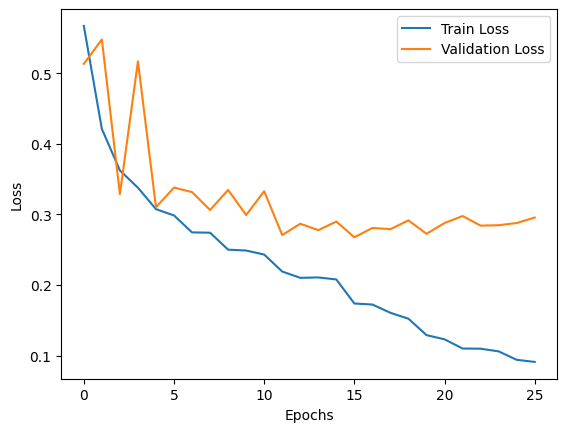

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define the model
model = Sequential([
    Dense(512, activation='relu', input_shape=(train_features_np.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),  # Dropout to prevent overfitting

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define EarlyStopping and ReduceLROnPlateau callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Allow training to continue for 10 epochs without improvement
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half
    patience=3,  # Wait for 3 epochs with no improvement
    min_lr=1e-6  # Set minimum learning rate
)

# Train the model with callbacks
history = model.fit(
    train_features_np.astype(np.float32), y_train,
    validation_data=(valid_features_np.astype(np.float32), y_valid),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
model.save("fake_news_detection_model.h5")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.88      0.89      0.89       750
     Class 1       0.89      0.88      0.88       750

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



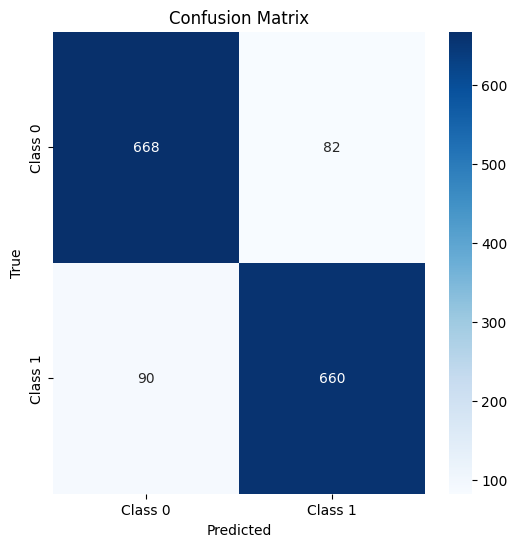

Accuracy: 0.8853
Precision: 0.8895
Recall: 0.8800
F1-Score: 0.8847
AUC: 0.9574


Testing Epochs: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]

Test loss: 0.2838, Test accuracy: 0.8853


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score

# Load your trained model (make sure the path to the model is correct)
model = load_model("fake_news_detection_model.h5")

# Make predictions on the test set
y_pred = model.predict(test_features_np.astype(np.float32))
y_pred_class = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class predictions

# Assuming y_test contains the true labels for the test set
y_test = np.array(y_test)  # Ensure y_test is in the correct format if needed

# Classification report (precision, recall, f1-score)
report = classification_report(y_test, y_pred_class, target_names=['Class 0', 'Class 1'])
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print Accuracy, Precision, Recall, F1-Score
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# AUC score (using roc_auc_score)
roc_auc_score_val = roc_auc_score(y_test, y_pred)
print(f"AUC: {roc_auc_score_val:.4f}")

# tqdm for testing epoch progress (not usually needed, but added for consistency in your request)
for epoch in tqdm(range(1), desc="Testing Epochs", ncols=100):
    # Use the test data to evaluate the model performance in one step
    loss, accuracy = model.evaluate(test_features_np.astype(np.float32), y_test, verbose=0)
    print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")